In [1]:
import sys
sys.path.insert(0, '..')
from SGD_QMT_v2 import *

## Figure 2

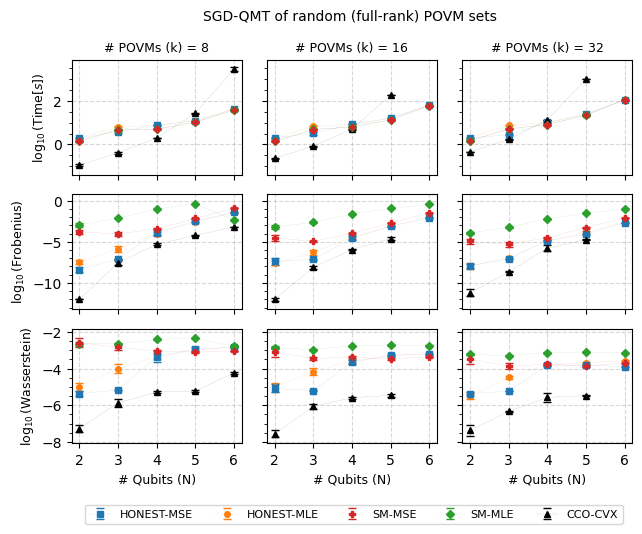

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

def load_results(filename):
    """Load original results saved in your format."""
    data = np.load(filename)
    return {
        "n_qubits": int(data["n_qubits"]),
        "povms": data["povms"],
        "methods": data["methods"],
        "time_avg": data["time_avg"],
        "time_std": data["time_std"],
        "frob_avg": data["frob_avg"],
        "frob_std": data["frob_std"],
        "wass_avg": data["wass_avg"],
        "wass_std": data["wass_std"],
    }

# Load original datasets
res2 = load_results("2qubits_results.npz")
res3 = load_results("3qubits_results.npz")
res4 = load_results("4qubits_results.npz")
res5 = load_results("5qubits_results.npz")
res6 = load_results("6qubits_results.npz")

all_results = [res2, res3, res4, res5, res6]

# Load LS datasets for 2–6 qubits
ls_files = [
    ("LS_results_2qubits.npz", 2, [2, 8, 16, 32]),
    ("LS_results_3qubits.npz", 3, [2, 8, 16, 32]),
    ("LS_results_4qubits.npz", 4, [2, 8, 16, 32]),
    ("LS_results_5qubits.npz", 5, [2, 8, 16, 32]),
    ("LS_results_6qubits.npz", 6, [2, 8]),
]

for filename, n_qubits, povm_list in ls_files:
    ls_data = np.load(filename)
    res_ls = {
        "n_qubits": n_qubits,
        "povms": np.array(povm_list),
        "methods": np.array(["LS"] * len(povm_list)),
        "time_avg": ls_data["time_avg"],
        "time_std": ls_data["time_std"],
        "frob_avg": ls_data["frob_avg"],
        "frob_std": ls_data["frob_std"],
        "wass_avg": ls_data["wass_avg"],
        "wass_std": ls_data["wass_std"],
    }
    all_results.append(res_ls)

# Parameters
N_list = sorted(set(res["n_qubits"] for res in all_results))
k_list = np.unique(np.concatenate([res["povms"] for res in all_results]))
k_list = [k for k in k_list if k != 2]  # remove POVM=2 case

markers = ['o', 's', '^', 'D', 'P']

# Manual color mapping for each method
method_colors = {
    "HONEST-MSE": "tab:blue",
    "HONEST-MLE": "tab:orange",
    "SM-MSE": "tab:red",
    "SM-MLE": "tab:green",
    "CCO-CVX": "k"
}

# Layout: 3 rows (time, frob, wass), columns = POVMs
fig, axs = plt.subplots(3, len(k_list), figsize=(6.5,5), sharex=True, sharey=False)

handles_dict = {}
log_values_per_row = [[] for _ in range(3)]

# Compute global y-limits
for col, k in enumerate(k_list):
    methods = np.unique(np.concatenate([res["methods"] for res in all_results]))
    for res in all_results:
        for method in methods:
            mask = (res["methods"] == method) & (res["povms"] == k)
            if np.any(mask):
                # Time
                vals = np.clip(res["time_avg"][mask], 1e-12, None)
                log_values_per_row[0].extend(np.log10(vals))
                # Frobenius
                vals = np.clip(res["frob_avg"][mask], 1e-12, None)
                log_values_per_row[1].extend(np.log10(vals))
                # Wasserstein
                vals = np.clip(res["wass_avg"][mask], 1e-12, None)
                log_values_per_row[2].extend(np.log10(vals))

# Global y-limits
y_lims = []
for log_vals in log_values_per_row:
    min_val, max_val = min(log_vals), max(log_vals)
    margin = 0.1 * (max_val - min_val) if max_val > min_val else 0.1
    y_lims.append((min_val - margin, max_val + margin))

# Plotting
for col, k in enumerate(k_list):
    methods = np.unique(np.concatenate([res["methods"] for res in all_results]))
    for i, method in enumerate(methods):
        xs, ys_time, ys_frob, ys_wass = [], [], [], []
        yerr_time, yerr_frob, yerr_wass = [], [], []

        # Collect data for this method & POVM
        for res in all_results:
            n = res["n_qubits"]
            mask = (res["methods"] == method) & (res["povms"] == k)
            if not np.any(mask):
                continue

            mean_time, std_time = res["time_avg"][mask][0], res["time_std"][mask][0]
            mean_frob, std_frob = res["frob_avg"][mask][0], res["frob_std"][mask][0]
            mean_wass, std_wass = res["wass_avg"][mask][0], res["wass_std"][mask][0]

            xs.append(n)
            ys_time.append(np.log10(mean_time))
            yerr_time.append(np.log10(mean_time + std_time) - np.log10(mean_time))

            ys_frob.append(np.log10(np.clip(mean_frob,1e-12,None)))
            yerr_frob.append(np.log10(np.clip(mean_frob+std_frob,1e-12,None)) - np.log10(np.clip(mean_frob,1e-12,None)))

            ys_wass.append(np.log10(np.clip(mean_wass,1e-12,None)))
            yerr_wass.append(np.log10(np.clip(mean_wass+std_wass,1e-12,None)) - np.log10(np.clip(mean_wass,1e-12,None)))

        if len(xs) == 0:
            continue

        # Determine legend name
        if method == "LS":
            legend_name = "CCO-CVX"
        elif method.upper() == "STIEFEL-MLE":
            legend_name = "SM-MLE"
        elif method.upper() == "STIEFEL-MSE":
            legend_name = "SM-MSE"
        else:
            legend_name = method.upper()

        color = method_colors[legend_name]

        # Row 0: Time
        ax = axs[0, col]
        line = ax.errorbar(xs, ys_time, yerr=yerr_time,
                    marker=markers[i % len(markers)],
                    color=color, linestyle='-', markersize=4, capsize=3,
                    linewidth=0.05)
        handles_dict[legend_name] = line
        ax.set_ylim(y_lims[0])
        ax.set_title(f"# POVMs (k) = {k}", fontsize=9)
        ax.set_xticks(N_list)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        if col == 0:
            ax.set_ylabel(r"$\log_{10}(\mathrm{Time}[s])$", fontsize=9)
        else:
            ax.set_yticklabels([])

        # Row 1: Frobenius
        ax = axs[1, col]
        ax.errorbar(xs, ys_frob, yerr=yerr_frob,
                    marker=markers[i % len(markers)],
                    color=color, linestyle='-', markersize=4, capsize=3,
                    linewidth=0.05)
        ax.set_ylim(y_lims[1])
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        if col == 0:
            ax.set_ylabel(r"$\log_{10}(\mathrm{Frobenius})$", fontsize=9)
        else:
            ax.set_yticklabels([])

        # Row 2: Wasserstein
        ax = axs[2, col]
        ax.errorbar(xs, ys_wass, yerr=yerr_wass,
                    marker=markers[i % len(markers)],
                    color=color, linestyle='-', markersize=4, capsize=3,
                    linewidth=0.05)
        ax.set_ylim(y_lims[2])
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        if col == 0:
            ax.set_ylabel(r"$\log_{10}(\mathrm{Wasserstein})$", fontsize=9)
        else:
            ax.set_yticklabels([])

# Shared xlabel
for ax in axs[-1, :]:
    ax.set_xlabel("# Qubits (N)", fontsize=9)


plt.rcParams.update({
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

# Fixed legend order
legend_order = ["HONEST-MSE", "HONEST-MLE", "SM-MSE", "SM-MLE", "CCO-CVX"]
handles_ordered = [handles_dict[name] for name in legend_order if name in handles_dict]

fig.legend(
    handles_ordered, legend_order,
    loc='lower center', ncol=len(legend_order), fontsize=8, frameon=True,
    bbox_to_anchor=(0.55, -0.06)
)

# Figure-level title
fig.suptitle("SGD-QMT of random (full-rank) POVM sets", fontsize=10, x=0.545, y=0.98)

plt.tight_layout(pad=1.0)
plt.subplots_adjust(hspace=0.17, wspace=0.15)

# plt.savefig('time-complexity.pdf', format='pdf', dpi=4000, bbox_inches='tight', pad_inches=0.01)
plt.show()

## Figure 3

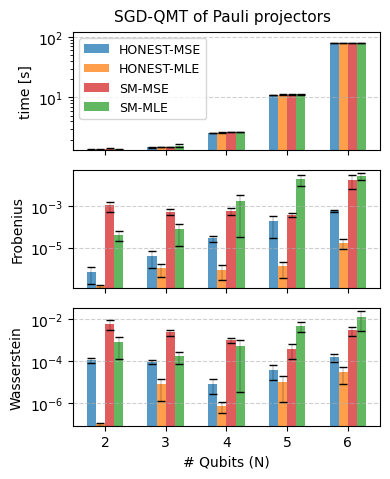

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob

# Collect result files
files = sorted(glob.glob("*qubits_pauli_results.npz"))

qubits = []
methods = None
time_avg_all, time_std_all = [], []
frob_avg_all, frob_std_all = [], []
wass_avg_all, wass_std_all = [], []

for f in files:
    data = np.load(f, allow_pickle=True)
    qubits.append(int(data["n_qubits"]))
    if methods is None:
        methods = list(data["methods"])
    time_avg_all.append(data["time_avg"])
    time_std_all.append(data["time_std"])
    frob_avg_all.append(data["frob_avg"])
    frob_std_all.append(data["frob_std"])
    wass_avg_all.append(data["wass_avg"])
    wass_std_all.append(data["wass_std"])

# Convert to arrays
time_avg_all, time_std_all = np.array(time_avg_all), np.array(time_std_all)
frob_avg_all, frob_std_all = np.array(frob_avg_all), np.array(frob_std_all)
wass_avg_all, wass_std_all = np.array(wass_avg_all), np.array(wass_std_all)

num_methods = len(methods)
num_qubits = len(qubits)
x = np.arange(num_qubits)  # positions for qubits
bar_width = 0.15

# Colors (consistent across plots)
colors = list(plt.cm.tab10.colors[:num_methods])

# Desired legend order and labels
legend_order = ["HONEST-MSE", "HONEST-MLE", "SM-MSE", "SM-MLE"]
# Map original methods to these labels
method_to_legend = dict(zip(methods, legend_order))

# --- Swap colors for specific methods ---
# Swap Stiefel-MSE and Stiefel-MLE
if "stiefel-mse" in methods and "stiefel-mle" in methods:
    i_mse = methods.index("stiefel-mse")
    i_mle = methods.index("stiefel-mle")
    colors[i_mse], colors[i_mle] = colors[i_mle], colors[i_mse]

# Swap SM-MSE and SM-MLE
sm_mse_idx = methods.index([k for k, v in method_to_legend.items() if v == "SM-MSE"][0])
sm_mle_idx = methods.index([k for k, v in method_to_legend.items() if v == "SM-MLE"][0])
colors[sm_mse_idx], colors[sm_mle_idx] = colors[sm_mle_idx], colors[sm_mse_idx]

# Create figure and axes
fig, axes = plt.subplots(3, 1, figsize=(4, 5), sharex=True)

# --- Helper plotting function ---
def plot_bars(ax, avg_all, std_all, ylabel, log=False, err_lw=1.0):
    for m_idx, method in enumerate(methods):
        # Plot bars
        ax.bar(
            x + m_idx * bar_width,
            avg_all[:, m_idx],
            width=bar_width,
            label=method_to_legend[method],  # use custom legend label
            color=colors[m_idx],
            alpha=0.75,
        )
        # Plot error bars
        ax.errorbar(
            x + m_idx * bar_width,
            avg_all[:, m_idx],
            yerr=std_all[:, m_idx],
            fmt='none',
            ecolor='black',
            elinewidth=err_lw,
            capsize=3,
        )

    ax.set_ylabel(ylabel)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    # Determine y-axis limits including error bars
    y_min = np.min(avg_all - std_all)
    y_max = np.max(avg_all + std_all)

    if log:
        ax.set_yscale("log")
        if y_min <= 0:
            y_min = np.min(avg_all[avg_all > 0]) * 0.5
        ax.set_ylim(bottom=y_min, top=y_max * 1.5)
    else:
        ax.set_ylim(bottom=0, top=y_max * 1.5)

# Plot all three metrics
plot_bars(axes[0], time_avg_all, time_std_all, "time [s]", log=True, err_lw=0.2)
plot_bars(axes[1], frob_avg_all, frob_std_all, "Frobenius", log=True, err_lw=0.2)
plot_bars(axes[2], wass_avg_all, wass_std_all, "Wasserstein", log=True, err_lw=0.2)

# Common x-axis
axes[2].set_xticks(x + (num_methods - 1) * bar_width / 2)
axes[2].set_xticklabels([f"{q}" for q in qubits])
axes[2].set_xlabel("# Qubits (N)")

# Create legend on top plot in exact order
handles, labels = axes[0].get_legend_handles_labels()
# Reorder handles according to legend_order
ordered_handles = [handles[methods.index(orig)] for orig in methods]
axes[0].legend(ordered_handles, legend_order, ncol=1, fontsize=9)

# Figure-level title
fig.suptitle("SGD-QMT of Pauli projectors", fontsize=11, x=0.57, y=0.95)

plt.tight_layout()
# plt.savefig('time-complexity-pauli.pdf', format='pdf', dpi=4000, bbox_inches='tight', pad_inches=0.01)
plt.show()

## Figure 4

/var/folders/ns/gddszqpn1nbb5mj1jhn_769r0000gn/T/ipykernel_2339/510689779.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("tab20", num_povms)
/var/folders/ns/gddszqpn1nbb5mj1jhn_769r0000gn/T/ipykernel_2339/510689779.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


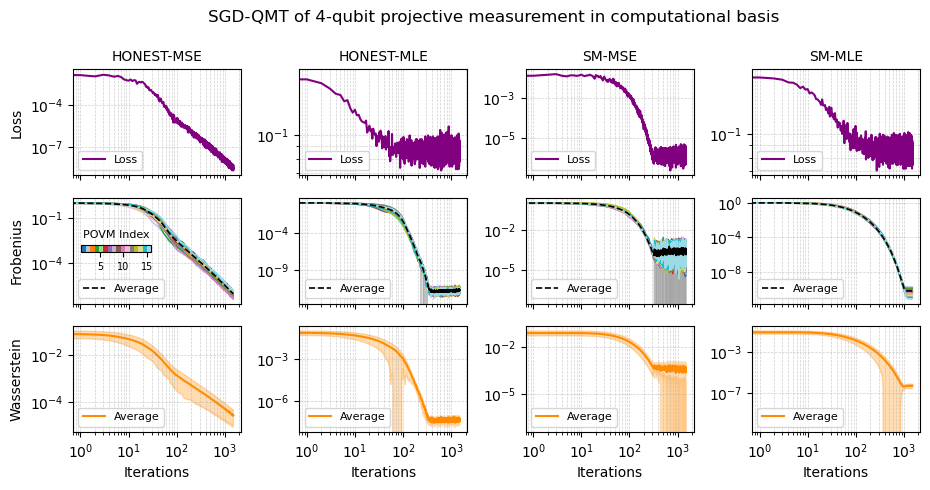

In [4]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import wasserstein_distance

# ============================================
# Helper function: compute metrics
# ============================================

def load_results_npz(filename="iteration_analysis.npz"):
    data = np.load(filename, allow_pickle=True)
    results = []
    idx = 0
    while f"frob_array_{idx}" in data:
        results.append((
            data[f"frob_array_{idx}"],
            data[f"avg_frob_{idx}"],
            data[f"std_frob_{idx}"],
            data[f"wasserstein_array_{idx}"],
            data[f"wasserstein_std_{idx}"],
            data[f"losses_{idx}"],
            str(data[f"method_name_{idx}"].item())
        ))
        idx += 1
    return results

def plot_all_methods(results):
    num_methods = len(results)
    fig, axs = plt.subplots(3, num_methods, figsize=(9.4, 4.9), sharex="col")

    if num_methods == 1:
        axs = np.array([[axs[0]], [axs[1]], [axs[2]]])  # ensure 2D array

    for col, (frob_array, avg_frob, std_frob, wasserstein_array, wasserstein_std, losses, method_name) in enumerate(results):
        num_steps, num_povms = frob_array.shape

        # Set column title
        axs[0, col].set_title(method_name, fontsize=10)

        # ---------------- Losses ----------------
        axs[0, col].plot(losses, color="purple", label="Loss")

        if col == 0:
            axs[0, col].set_ylabel("Loss", fontsize=10)
        else:
            axs[0, col].set_ylabel("")

        axs[0, col].set_xscale("log")
        axs[0, col].set_yscale("log")
        axs[0, col].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)
        axs[0, col].legend(loc="lower left", fontsize=6.5, frameon=True, prop={"size": 8})
        

        # ---------------- Frobenius ----------------
        colors = cm.get_cmap("tab20", num_povms)
        for i in range(num_povms):
            axs[1, col].plot(frob_array[:, i], color=colors(i), linewidth=1)
        axs[1, col].plot(avg_frob, color="black", linewidth=1.2, linestyle="--", label="Average")
        axs[1, col].fill_between(np.arange(num_steps), avg_frob-std_frob, avg_frob+std_frob,
                        color="black", alpha=0.2)

        if col == 0:
            axs[1, col].set_ylabel("Frobenius", fontsize=10)
        else:
            axs[1, col].set_ylabel("")

        axs[1, col].set_xscale("log")
        axs[1, col].set_yscale("log")
        axs[1, col].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)
        axs[1, col].legend(loc="lower left", fontsize=6.5, frameon=True, prop={"size": 8})

# ---------------- POVM index colorbar (first column only) ----------------
        if col == 0:
            sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=1, vmax=num_povms))
            cax = inset_axes(
                axs[1, col],
                width=0.7, 
                height=0.07, 
                loc='lower left',
                bbox_to_anchor=(0.01, 0.42),  # adjust placement
                bbox_transform=axs[1, col].transAxes
            )
            cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
            cbar.set_label("POVM Index", fontsize=8, labelpad=5)
            # make ticks vertical & neat
            cbar.ax.tick_params(labelsize=7, rotation=0)
            cbar.ax.xaxis.set_label_position("top")
        
        # ---------------- Wasserstein ----------------
        axs[2, col].plot(wasserstein_array, color="darkorange", label="Average")
        axs[2, col].fill_between(np.arange(num_steps), wasserstein_array-wasserstein_std, wasserstein_array+wasserstein_std,
                                color="darkorange", alpha=0.3)

        if col > 0:
            axs[2, col].set_ylabel("")
        else:
            axs[2, col].set_ylabel("Wasserstein", fontsize=10)

        axs[2, col].set_xlabel("Iterations", fontsize=10)
        axs[2, col].set_xscale("log")
        axs[2, col].set_yscale("log")
        axs[2, col].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)
        axs[2, col].legend(loc="lower left", fontsize=6.5, frameon=True, prop={"size": 8})

    
    # Figure-level title
    fig.suptitle("SGD-QMT of 4-qubit projective measurement in computational basis", fontsize=12, x=0.53, y=0.99)

    plt.tight_layout()
    # plt.savefig('iteration-analysis-computational-4qubit.pdf', format='pdf', dpi=4000, bbox_inches='tight', pad_inches=0.01)
    plt.show()

# # ============================================
# # Example usage 
# # ============================================

# Later: load and plot
loaded_results = load_results_npz("iteration_analysis.npz")
plot_all_methods(loaded_results)

## Figure 5

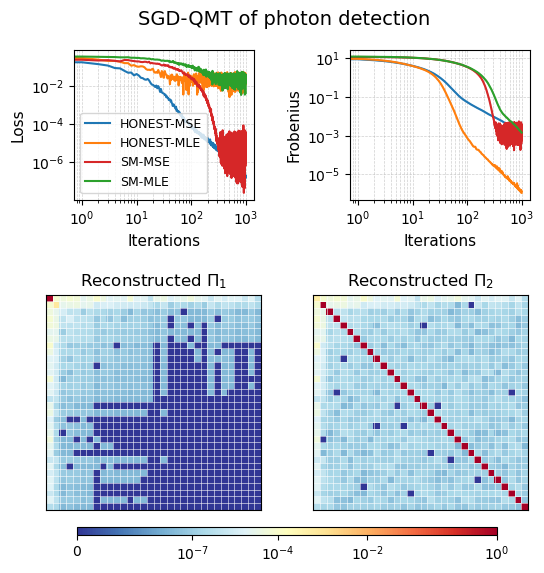

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from matplotlib.colors import LogNorm, PowerNorm
# from cmap import Colormap  # only needed if using custom colormaps

# ============================================
# Helper function: compute metrics
# ============================================

def analyze_method(true_povms, probe_states, target_probs, recon_povms_step, losses, method_name, final_recon_povms):
    num_steps = len(recon_povms_step)
    num_povms = len(true_povms)
    num_states = len(probe_states)

    frob_array = np.zeros((num_steps, num_povms))
    wasserstein_array = np.zeros(num_steps)
    wasserstein_std = np.zeros(num_steps)

    for step, recon_povs in enumerate(recon_povms_step):
        # Frobenius norms (per POVM element)
        frob_step = []
        for i in range(num_povms):
            E, F = true_povms[i], recon_povs[i]
            frob_sq = jnp.linalg.norm(E - F, ord="fro") ** 2
            frob_step.append(frob_sq)
        frob_array[step] = np.array(frob_step)

        # Wasserstein distance (per probe state)
        all_pred_probs = simulate_measurements(recon_povs, probe_states)
        wass_per_state = np.array([
            wasserstein_distance(target_probs[i], all_pred_probs[i])
            for i in range(num_states)
        ])
        wasserstein_array[step] = np.mean(wass_per_state)
        wasserstein_std[step] = np.std(wass_per_state)

    avg_frob = frob_array.mean(axis=1)
    std_frob = frob_array.std(axis=1)

    # return also the final reconstructed POVMs
    return frob_array, avg_frob, std_frob, wasserstein_array, wasserstein_std, losses, method_name, final_recon_povms


# ============================================
# Save / Load Results
# ============================================

def save_results_npz(results, filename="photon_detection_iteration_analysis.npz"):
    npz_dict = {}
    for idx, (frob_array, avg_frob, std_frob, wasserstein_array,
              wasserstein_std, losses, method_name, final_recon_povms) in enumerate(results):
        npz_dict[f"frob_array_{idx}"] = frob_array
        npz_dict[f"avg_frob_{idx}"] = avg_frob
        npz_dict[f"std_frob_{idx}"] = std_frob
        npz_dict[f"wasserstein_array_{idx}"] = wasserstein_array
        npz_dict[f"wasserstein_std_{idx}"] = wasserstein_std
        npz_dict[f"losses_{idx}"] = losses
        npz_dict[f"method_name_{idx}"] = np.array(method_name)
        npz_dict[f"recon_povms_{idx}"] = final_recon_povms
    np.savez(filename, **npz_dict)


def load_results_npz(filename="photon_detection_iteration_analysis.npz"):
    data = np.load(filename, allow_pickle=True)
    results = []
    idx = 0
    while f"frob_array_{idx}" in data:
        results.append((
            data[f"frob_array_{idx}"],
            data[f"avg_frob_{idx}"],
            data[f"std_frob_{idx}"],
            data[f"wasserstein_array_{idx}"],
            data[f"wasserstein_std_{idx}"],
            data[f"losses_{idx}"],
            str(data[f"method_name_{idx}"].item()),
            data[f"recon_povms_{idx}"],
        ))
        idx += 1
    return results


# ============================================
# Plotting
# ============================================

def plot_analysis_with_recon_povms_heatmap(results, recon_povms, m, cmap="copper_r",
                                            heatmap_width=0.35, heatmap_height=0.35,
                                            heatmap_x_shift=[0.1, 0.55],
                                            heatmap_y_shift=[0.05, 0.05]):
    """
    2x2 figure: top row = loss & Frobenius, bottom row = reconstructed POVMs as square heatmaps.
    """
    num_methods = len(results)
    num_povms = recon_povms.shape[0]
    assert m <= 2, "Max 2 POVMs for bottom row in 2x2 layout"

    fig = plt.figure(figsize=(6,5))  # slightly larger to avoid overlaps

    colors = list(plt.cm.tab10.colors[:num_methods])
    method_names = [r[-2] for r in results]  # method_name is second last
    if "SM-MSE" in method_names and "SM-MLE" in method_names:
        i_mse = method_names.index("SM-MSE")
        i_mle = method_names.index("SM-MLE")
        colors[i_mse], colors[i_mle] = colors[i_mle], colors[i_mse]

    # --- Top row: Loss plot ---
    ax1 = fig.add_subplot(2, 2, 1)
    for i, (_, _, _, _, _, losses, method_name, _) in enumerate(results):
        ax1.plot(losses, label=method_name, color=colors[i], linewidth=1.5)
    ax1.set_xlabel("Iterations", fontsize=11)
    ax1.set_ylabel("Loss", fontsize=11)
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)
    ax1.legend(fontsize=9, frameon=True)
    ax1.set_position([0.1, 0.55, 0.3, 0.3])

    # --- Top row: Frobenius plot ---
    ax2 = fig.add_subplot(2, 2, 2)
    for i, (_, avg_frob, std_frob, _, _, _, method_name, _) in enumerate(results):
        num_steps = len(avg_frob)
        ax2.plot(avg_frob, label=method_name, color=colors[i], linewidth=1.5)
        ax2.fill_between(np.arange(num_steps),
                         avg_frob - std_frob, avg_frob + std_frob,
                         color=colors[i], alpha=0.2)
    ax2.set_xlabel("Iterations", fontsize=11)
    ax2.set_ylabel("Frobenius", fontsize=11)
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)
    ax2.set_position([0.56, 0.55, 0.3, 0.3])

    # --- Bottom row: POVM Heatmaps ---
    selected_indices = np.arange(m)
    vmax = float(jnp.max(jnp.abs(recon_povms)))
    vmin = vmax * 1e-3
    im_list = []

    for j, idx in enumerate(selected_indices):
        ax = fig.add_axes([heatmap_x_shift[j], heatmap_y_shift[j], heatmap_width, heatmap_height])
        data = np.abs(recon_povms[idx])
        im = ax.imshow(data, cmap=cmap,
                       norm=PowerNorm(gamma=0.08, vmin=0, vmax=np.max(data)),
                       interpolation="none", origin="upper", aspect="equal")
        im_list.append(im)
        ax.set_title(rf"Reconstructed $\Pi_{{{j+1}}}$", fontsize=12)
        ax.set_xticks(np.arange(data.shape[1]+1)-0.5, minor=True)
        ax.set_yticks(np.arange(data.shape[0]+1)-0.5, minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=0.4)
        ax.tick_params(which="minor", bottom=False, left=False)
        ax.set_xticks([])
        ax.set_yticks([])

    # --- Common colorbar ---
    cbar_ax = fig.add_axes([0.105, -0.12, 0.7, 0.015])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    vmin, vmax = 0, np.max(data)
    tick_values = np.array([0, 0.0000001*vmax, 0.0001*vmax, 0.01*vmax, vmax])
    cbar.set_ticks(tick_values)
    tick_labels = []
    for v in tick_values:
        if v == 0:
            tick_labels.append("0")
        else:
            exponent = int(np.round(np.log10(v)))
            tick_labels.append(r"$10^{{{}}}$".format(exponent))
    cbar.set_ticklabels(tick_labels)

    fig.suptitle("SGD-QMT of photon detection", fontsize=14, x=0.45, y=0.93)
    # plt.savefig("photon_detection_iteration_analysis.pdf",
    #             format="pdf", dpi=4000, bbox_inches="tight", pad_inches=0.01)
    plt.show()


# ============================================
# Example usage
# ============================================

# all_methods_outputs = [
#     (recon_povms1, final_probs1, losses1, times1, recon_povms_step1, total_time1, "HONEST-MSE"),
#     (recon_povms2, final_probs2, losses2, times2, recon_povms_step2, total_time2, "HONEST-MLE"),
#     (recon_povms3, final_probs3, losses3, times3, recon_povms_step3, total_time3, "SM-MSE"),
#     (recon_povms4, final_probs4, losses4, times4, recon_povms_step4, total_time4, "SM-MLE"),
# ]
#
# results = []
# for (recon_povms, final_probs, losses, times, recon_povms_step, total_time, method_name) in all_methods_outputs:
#     results.append(analyze_method(true_povms, probe_states, target_probs,
#                                   recon_povms_step, losses, method_name, recon_povms))
#
# save_results_npz(results, "photon_detection_iteration_analysis.npz")
#
loaded_results = load_results_npz("photon_detection_iteration_analysis.npz")

# Example: plot using method 2 (HONEST-MLE)
recon_povms2 = loaded_results[1][-1]  # final POVMs for method 2
plot_analysis_with_recon_povms_heatmap(loaded_results, recon_povms2, 2, cmap="RdYlBu_r",
                                            heatmap_width=0.43, heatmap_height=0.43,
                                            heatmap_x_shift=[0.018, 0.463],
                                            heatmap_y_shift=[-0.07, -0.07])

## Figure 6

/var/folders/ns/gddszqpn1nbb5mj1jhn_769r0000gn/T/ipykernel_2339/285691671.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("rainbow", num_povms)
/var/folders/ns/gddszqpn1nbb5mj1jhn_769r0000gn/T/ipykernel_2339/285691671.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("rainbow", num_povms)
/var/folders/ns/gddszqpn1nbb5mj1jhn_769r0000gn/T/ipykernel_2339/285691671.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm

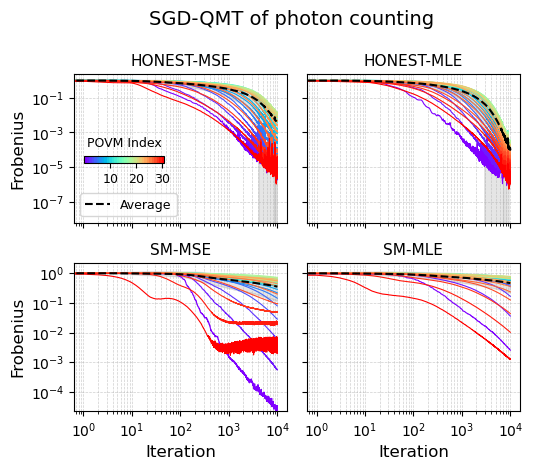

In [6]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import wasserstein_distance

# ============================================
# Helper function: compute metrics
# ============================================

def analyze_method(true_povms, probe_states, target_probs, recon_povms_step, losses, method_name):
    num_steps = len(recon_povms_step)
    num_povms = len(true_povms)
    num_states = len(probe_states)

    frob_array = np.zeros((num_steps, num_povms))
    wasserstein_array = np.zeros(num_steps)
    wasserstein_std = np.zeros(num_steps)

    for step, recon_povs in enumerate(recon_povms_step):
        # Frobenius norms (per POVM element)
        frob_step = []
        for i in range(num_povms):
            E, F = true_povms[i], recon_povs[i]
            frob_sq = jnp.linalg.norm(E - F, ord="fro") ** 2
            frob_step.append(frob_sq)
        frob_array[step] = np.array(frob_step)

        # Wasserstein distance (per probe state)
        all_pred_probs = simulate_measurements(recon_povs, probe_states)
        wass_per_state = np.array([
            wasserstein_distance(target_probs[i], all_pred_probs[i])
            for i in range(num_states)
        ])
        wasserstein_array[step] = np.mean(wass_per_state)
        wasserstein_std[step] = np.std(wass_per_state)

    avg_frob = frob_array.mean(axis=1)
    std_frob = frob_array.std(axis=1)

    # also return losses
    return frob_array, avg_frob, std_frob, wasserstein_array, wasserstein_std, losses, method_name


def save_results_npz(results, filename="photon_counting.npz"):
    npz_dict = {}
    for idx, (frob_array, avg_frob, std_frob, wasserstein_array, wasserstein_std, losses, method_name) in enumerate(results):
        npz_dict[f"frob_array_{idx}"] = frob_array
        npz_dict[f"avg_frob_{idx}"] = avg_frob
        npz_dict[f"std_frob_{idx}"] = std_frob
        npz_dict[f"wasserstein_array_{idx}"] = wasserstein_array
        npz_dict[f"wasserstein_std_{idx}"] = wasserstein_std
        npz_dict[f"losses_{idx}"] = losses
        npz_dict[f"method_name_{idx}"] = np.array(method_name)
    np.savez(filename, **npz_dict)


def load_results_npz(filename="photon_counting.npz"):
    data = np.load(filename, allow_pickle=True)
    results = []
    idx = 0
    while f"frob_array_{idx}" in data:
        results.append((
            data[f"frob_array_{idx}"],
            data[f"avg_frob_{idx}"],
            data[f"std_frob_{idx}"],
            data[f"wasserstein_array_{idx}"],
            data[f"wasserstein_std_{idx}"],
            data[f"losses_{idx}"],
            str(data[f"method_name_{idx}"].item())
        ))
        idx += 1
    return results



def plot_frobenius_only(results):
    """
    Plot Frobenius norm curves for multiple methods
    in a 2x2 grid (one subplot per method).
    - Top row: shared y-axis range (global)
    - Bottom row: shared y-axis range (auto-detected from bottom-row data only)
    - Adds headroom to max y-axis
    - Colorbar (POVM index) only in first subplot
    - No y-axis labels/ticks in right column
    - No x-axis labels/ticks in top row
    """
    num_methods = len(results)
    rows, cols = 2, 2
    fig, axs = plt.subplots(rows, cols, figsize=(5.4,4.7))
    axs = axs.flatten()

    # ---------- Determine y-axis limits for top row ----------
    all_values = []
    for (frob_array, avg_frob, std_frob, _, _, _, _) in results:
        all_values.append(frob_array)
        all_values.append(avg_frob - std_frob)
        all_values.append(avg_frob + std_frob)
    all_values = np.concatenate([v.reshape(-1) for v in all_values])
    y_min_top = np.nanmin(all_values[all_values > 0])  # ignore zeros for log scale
    y_max_top = np.nanmax(all_values) * 2

    # ---------- Determine y-axis limits for bottom row ----------
    bottom_values = []
    for idx, (frob_array, avg_frob, std_frob, _, _, _, _) in enumerate(results):
        row, _ = divmod(idx, cols)
        if row == 1:  # bottom row only
            bottom_values.append(frob_array)
            bottom_values.append(avg_frob - std_frob)
            bottom_values.append(avg_frob + std_frob)
    if bottom_values:  # only compute if bottom row exists
        bottom_values = np.concatenate([v.reshape(-1) for v in bottom_values])
        y_min_bottom = np.nanmin(bottom_values[bottom_values > 0])
        y_max_bottom = np.nanmax(bottom_values) * 2
    else:
        y_min_bottom, y_max_bottom = None, None

    # ---------- Plotting ----------
    for col, (frob_array, avg_frob, std_frob, _, _, _, method_name) in enumerate(results):
        num_steps, num_povms = frob_array.shape
        ax = axs[col]

        # Colormap
        colors = cm.get_cmap("rainbow", num_povms)

        # Plot each POVM
        for i in range(num_povms):
            ax.plot(frob_array[:, i], color=colors(i), linewidth=0.8)

        # Average + std shading
        ax.plot(avg_frob, color="black", linewidth=1.5, linestyle="--", label="Average")
        ax.fill_between(
            np.arange(num_steps),
            avg_frob - std_frob,
            avg_frob + std_frob,
            color="black",
            alpha=0.1,
        )

        ax.set_title(method_name, fontsize=11)
        ax.set_xscale("log")
        ax.set_yscale("log")
        
        # Remove minor ticks on y-axis
        ax.yaxis.set_minor_locator(plt.NullLocator())

        ax.grid(True, which="both", axis="x", linestyle="--", linewidth=0.5, alpha=0.6)
        ax.grid(True, which="major", axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

        # Apply y-axis limits
        row, col_idx = divmod(col, cols)
        if row == 0:  # top row
            ax.set_ylim(y_min_top, y_max_top)
        elif row == 1 and y_min_bottom and y_max_bottom:  # bottom row
            ax.set_ylim(y_min_bottom, y_max_bottom)

        # Axis label handling
        if col_idx == 1:  # right column → remove y-labels and ticks
            ax.set_ylabel("")
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("Frobenius", fontsize=12)

        if row == 0:  # top row → remove x-labels and ticks
            ax.set_xlabel("")
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("Iteration", fontsize=12)

        # Legend + colorbar only in first subplot
        if col == 0:
            ax.legend(loc="lower left", fontsize=9, frameon=True, prop={"size": 9})

            # POVM index colorbar
            sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=0, vmax=num_povms-1))
            cax = inset_axes(
                ax,
                width=0.8,
                height=0.07,
                loc="lower left",
                bbox_to_anchor=(0.05, 0.40),
                bbox_transform=ax.transAxes,
                borderpad=0,
            )
            cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
            cbar.set_label("POVM Index", fontsize=9, labelpad=7)
            cbar.ax.tick_params(labelsize=9, rotation=0)
            cbar.ax.xaxis.set_label_position("top")
            cbar.set_ticks([10, 20, 30])
            cbar.set_ticklabels(["10", "20", "30"])

    # Hide unused subplots if < 4 methods
    for i in range(num_methods, rows * cols):
        fig.delaxes(axs[i])


    fig.suptitle("SGD-QMT of photon counting", fontsize=14, x=0.55, y=0.99)

    plt.tight_layout()
    # plt.savefig("photon_counting.pdf", format="pdf", dpi=4000, bbox_inches="tight", pad_inches=0.01)
    plt.show()

# Later: load and plot
loaded_results = load_results_npz("photon_counting.npz")
plot_frobenius_only(loaded_results)

## Figure 7

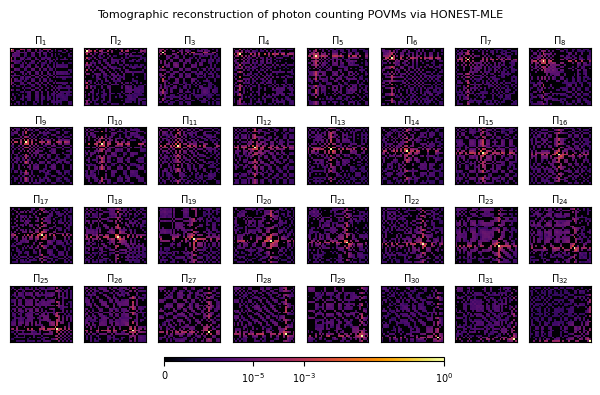

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import PowerNorm

def plot_povms(povms, savepath="povms_grid_photon_counting.pdf"):
    """
    Plot POVM operators (list/array of shape (32, 32, 32)) 
    as heatmaps in a 4x8 grid with nonlinear colormap scaling
    to enhance visibility of small values.
    """
    povms = np.array(povms)
    num_povms = povms.shape[0]
    assert num_povms == 32, "Expected 32 POVM operators."

    rows, cols = 4, 8
    fig, axs = plt.subplots(rows, cols, figsize=(7.0, 3.5))  # APS double-column width
    
    # Global color scale
    vmax = np.max(povms)
    norm = PowerNorm(gamma=0.1, vmin=0, vmax=vmax)  # gamma < 1 → stretch small values

    for idx, ax in enumerate(axs.flat):
        mat = povms[idx]
        im = ax.imshow(
            mat, cmap="inferno", norm=norm,
            interpolation="nearest", aspect="auto"
        )
        ax.set_title(rf"$\Pi_{{{idx+1}}}$", fontsize=7, pad=2)
        ax.set_xticks([])
        ax.set_yticks([])

    # Adjust layout
    fig.subplots_adjust(
        left=0.05, right=0.88, top=0.92, bottom=0.08, wspace=0.2, hspace=0.4
    )

    # Shared colorbar
    cbar_ax = fig.add_axes([0.27, 0.025, 0.4, 0.012]) # position: [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label="")

    # Optional: scientific tick labels
    vmax = np.max(povms)
    tick_values = [0, 0.00001*vmax, 0.001*vmax, vmax]
    cbar.set_ticks(tick_values)
    cbar.ax.tick_params(labelsize=7)  # reduce font size of tick labels
    tick_labels = []
    for v in tick_values:
        if v == 0:
            tick_labels.append("0")
        else:
            exponent = int(np.round(np.log10(v)))
            tick_labels.append(r"$10^{{{}}}$".format(exponent))
    cbar.set_ticklabels(tick_labels)

    fig.suptitle(
        "Tomographic reconstruction of photon counting POVMs via HONEST-MLE",
        fontsize=8.1, x=0.464, y=1.03
    )

    # plt.savefig(savepath, format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.01)
    plt.show()

data = np.load("photon_counting_povms.npz")
recon_povm = data["povms"]
plot_povms(recon_povm, savepath="povms_grid_photon_counting.pdf")

## Figure 8

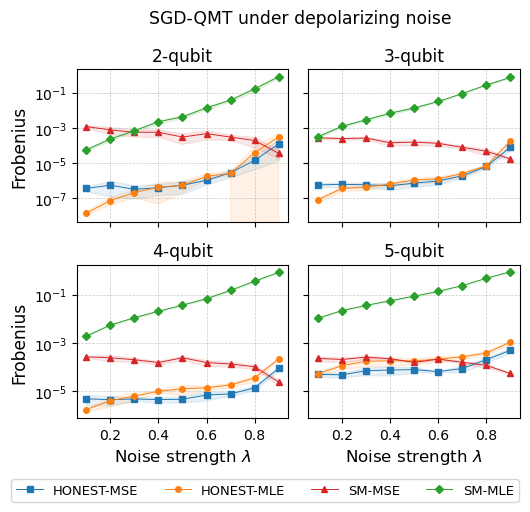

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_frobenius_results(qubit_list=[3,4,5,6]):
    fig, axes = plt.subplots(2, 2, figsize=(5.4,4.5), sharex='col', sharey='row')
    axes = axes.flatten()

    # Color + Marker maps
    color_map = {
        "HONEST-MSE": "C0",
        "HONEST-MLE": "C1",
        "SM-MSE": "C3",  # swapped color
        "SM-MLE": "C2"   # swapped color
    }
    marker_map = {
        "HONEST-MSE": "s",
        "HONEST-MLE": "o",
        "SM-MSE": "^",
        "SM-MLE": "D"
    }

    legend_lines = {}

    for idx, n_qubits in enumerate(qubit_list):
        ax = axes[idx]
        data = np.load(f"noise-{n_qubits}.npz", allow_pickle=True)
        results = data["results"]
        methods = data["methods"]
        p_values = data["p_values"]

        mean_results = results.mean(axis=-1)
        std_results = results.std(axis=-1)

        for im, method in enumerate(methods):
            mean_vals = mean_results[im]
            std_vals = std_results[im]

            color = color_map.get(method, f"C{im}")
            marker = marker_map.get(method, "o")

            line, = ax.plot(
                p_values,
                mean_vals,
                marker=marker,
                color=color,
                markersize=4,
                linewidth=0.7
            )
            ax.fill_between(
                p_values,
                mean_vals - std_vals,
                mean_vals + std_vals,
                alpha=0.1,
                color=color
            )

            if method not in legend_lines:
                legend_lines[method] = line

        ax.set_title(f"{n_qubits}-qubit", fontsize=12.3)
        ax.set_yscale("log")

        if idx % 2 == 0:
            ax.set_ylabel("Frobenius", fontsize=12.3)
        else:
            ax.set_ylabel("")
            ax.tick_params(labelleft=False)

        if idx // 2 == 1:
            ax.set_xlabel("Noise strength $\lambda$", fontsize=12)
        else:
            ax.set_xlabel("")
            ax.tick_params(labelbottom=False)
        
        # Add grid lines
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    plt.tight_layout()

    fig.legend(
        handles=list(legend_lines.values()),
        labels=list(legend_lines.keys()),
        loc='lower center',
        ncol=len(legend_lines),
        fontsize=9.4,
        frameon=True,
        bbox_to_anchor=(0.50, -0.06)
    )

    fig.suptitle(
        "SGD-QMT under depolarizing noise",
        fontsize=12.4, x=0.565, y=1.05
    )
    # Save as PDF with high resolution
    # plt.savefig('noise-QMT.pdf', format='pdf', dpi=4000, bbox_inches='tight', pad_inches=0.01)
    plt.show()

plot_frobenius_results(qubit_list=[2,3,4,5])